## 一、 将分钟数据输入HFDataView(1-5月的BHC数据)
1. 初始化不同周期的DataView
2. 读取Excel数据并合并数据
3. 处理数据格式，需要传入一个multiindex的数据，用来初始化dv。
4. 合成不同周期的数据并传入对应的DataView

## 1. 初始化不同周期的DataView

In [1]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1 = HFDataView()
dv5 = HFDataView()
dv15 = HFDataView()
dv30 = HFDataView()
dv60 = HFDataView()
dv240 = HFDataView()
dv480 = HFDataView()

## 2. 读取csv数据

In [2]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")
data_excel = pd.read_csv('bch_usdt.csv').iloc[:,1:]

In [5]:
data_excel['time'] = pd.Index(map(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S") , data_excel['time']))

## 3. 处理数据格式，需要传入一个multiindex的数据，用来初始化dv。
要求:trade_date、symbol为index， fields为columns. 其中,trade_date要为整数类型

In [6]:
data_excel["trade_date"] = data_excel["time"].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
data_excel["symbol"] = "btc_usdt"
data_excel['usdt'] = 6.4
data_excel = data_excel.set_index(["trade_date","symbol"])
dv1.create_init_dv(data_excel) # 用来初始化dv

Initialize dataview success.


## 4. 合成不同周期的数据并传入对应的DataView
1. 用resample合并成不同周期的Bar数据
2. 传入对应的DataView

In [7]:
data_time = data_excel.set_index('time').dropna()

In [8]:
TimePeriodDict = {t:data_time.resample(t).agg({'high':'max','open':'first','close':'last','low':'min','volume':'sum','amount':'sum'}).dropna() for t in ['5Min', '15Min', "30Min", '1H', '4H', '8H']}

In [9]:
def Time_Dict(t_list=['5Min', '15Min', "30Min", '1H', '4H', '8H']):
    for t in t_list:
        TimePeriodDict[t]['time'] = TimePeriodDict[t].index
        TimePeriodDict[t]["trade_date"] = TimePeriodDict[t]['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
        TimePeriodDict[t]["symbol"] = "btc_usdt"
        TimePeriodDict[t]['usdt'] = 6.4
        TimePeriodDict[t] = TimePeriodDict[t].set_index(["trade_date","symbol"])
    return TimePeriodDict

In [10]:
Time_dict = Time_Dict()

In [11]:
dv5.create_init_dv(Time_dict['5Min'])
dv15.create_init_dv(Time_dict['15Min'])
dv30.create_init_dv(Time_dict['30Min'])
dv60.create_init_dv(Time_dict['1H'])
dv240.create_init_dv(Time_dict['4H'])
dv480.create_init_dv(Time_dict['8H'])

Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.


## 二、计算不同周期的Alpha指标

### 计算VWAP

In [12]:
for dv in [dv1, dv5, dv15, dv30, dv60, dv240, dv480]:
    dv.add_formula('vwap_c','amount/(volume*usdt)', add_data=True)

### 计算Alpha1

In [13]:
 for dv in [dv1, dv5, dv15, dv30, dv60, dv240, dv480]:
        dv.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)

## 三、 TimingDigger的使用案例

In [14]:
import talib as ta
import matplotlib.pyplot as plt

def Plot_MA(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(ta.MA(alpha.values, ShortPeriod), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(ta.MA(alpha.values, LongPeriod), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [42]:
def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [15]:
# dv5.get_ts('alpha1_C', date_type='datetime')

In [16]:
dv_dict = {'alpha1_dv1':dv1, 'alpha1_dv5': dv5, 'alpha1_dv15':dv15, 'alpha1_dv30':dv30, 'alpha1_dv60':dv60, 'alpha1_dv240':dv240, 'alpha1_dv480':dv480}
alpha1_dict = {n: dv.get_ts('alpha1_C', date_type='datetime').btc_usdt for n, dv in dv_dict.items()}

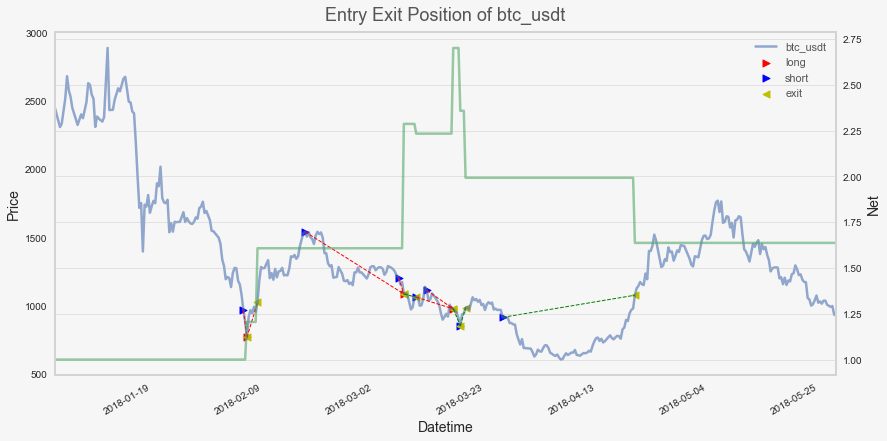

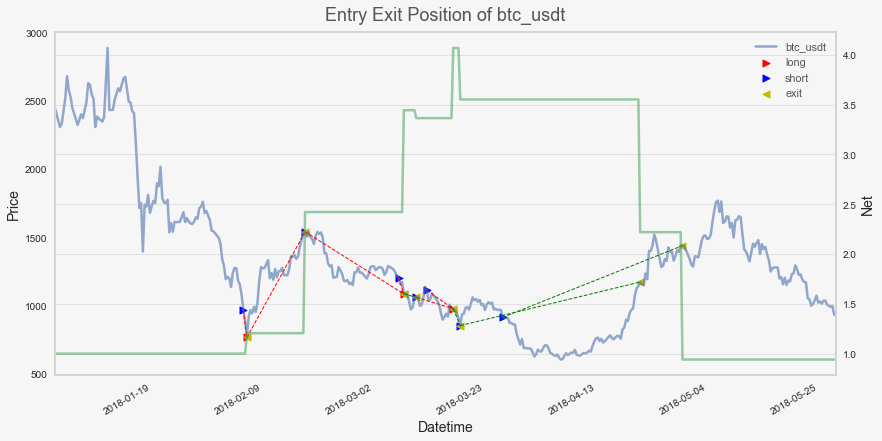

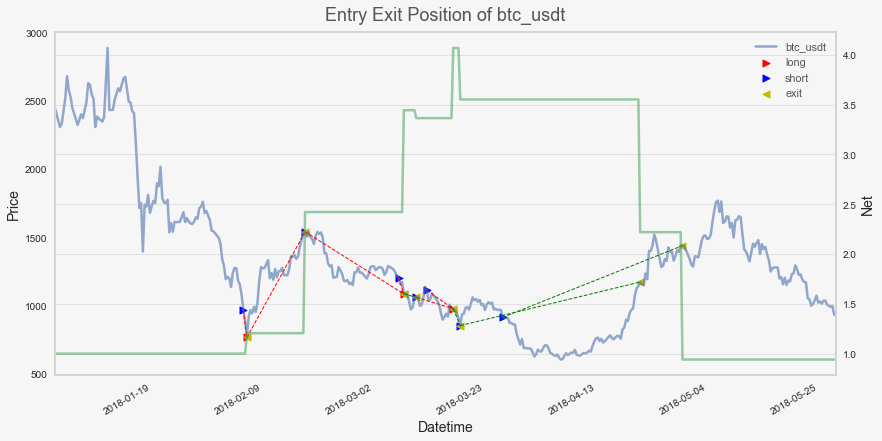

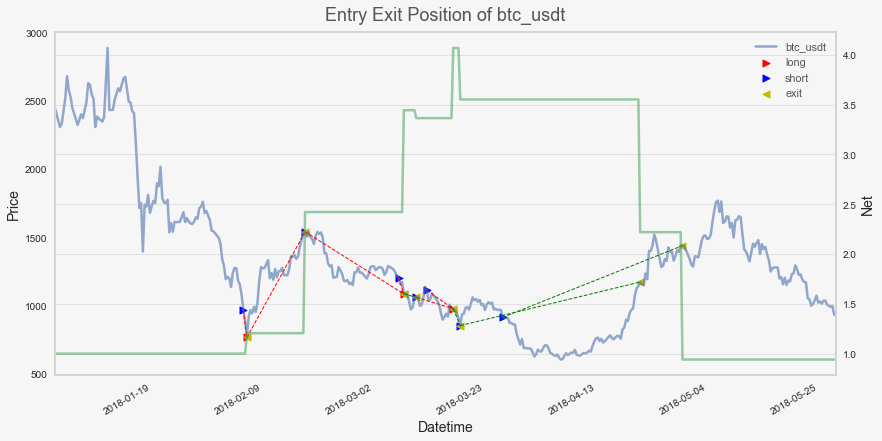

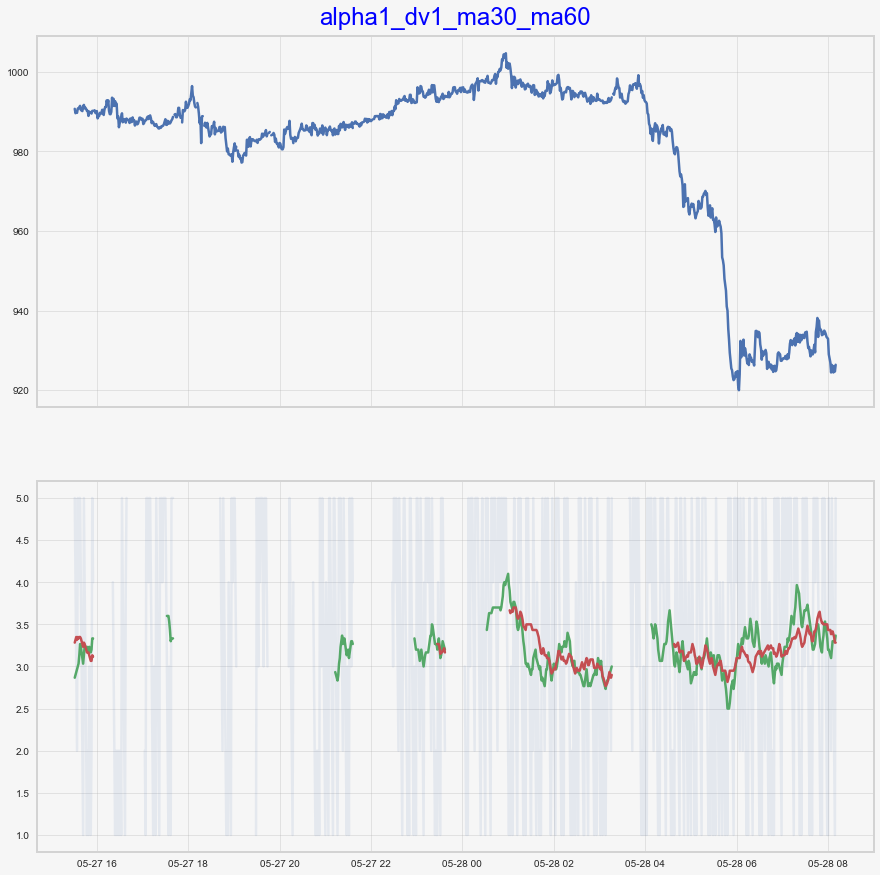

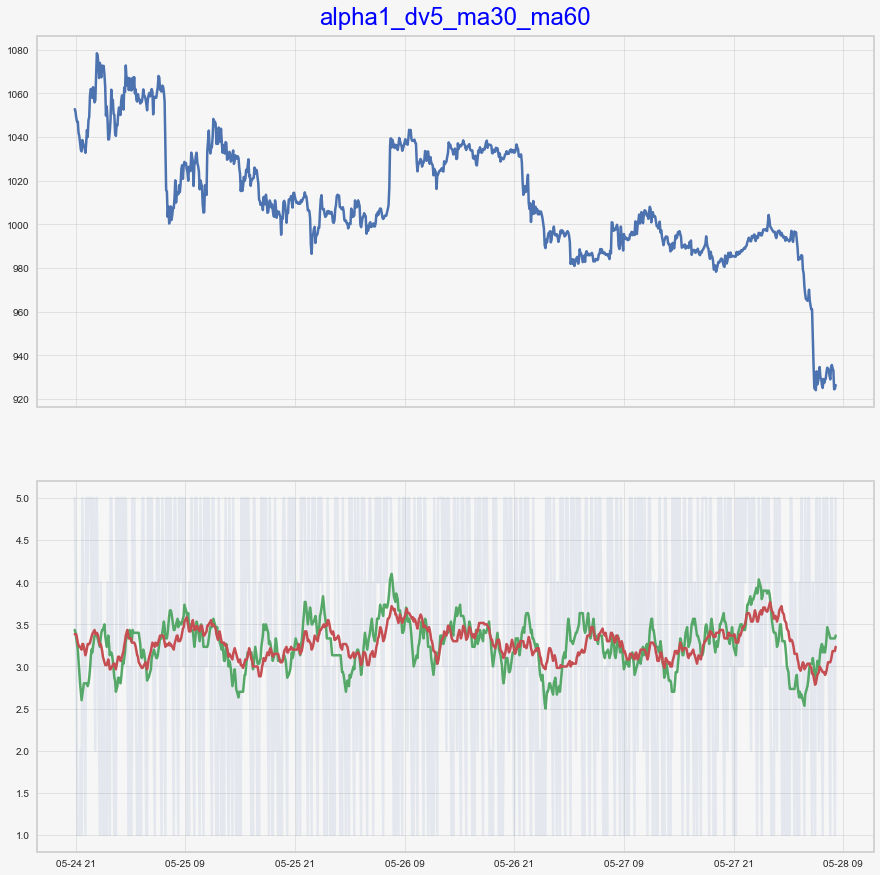

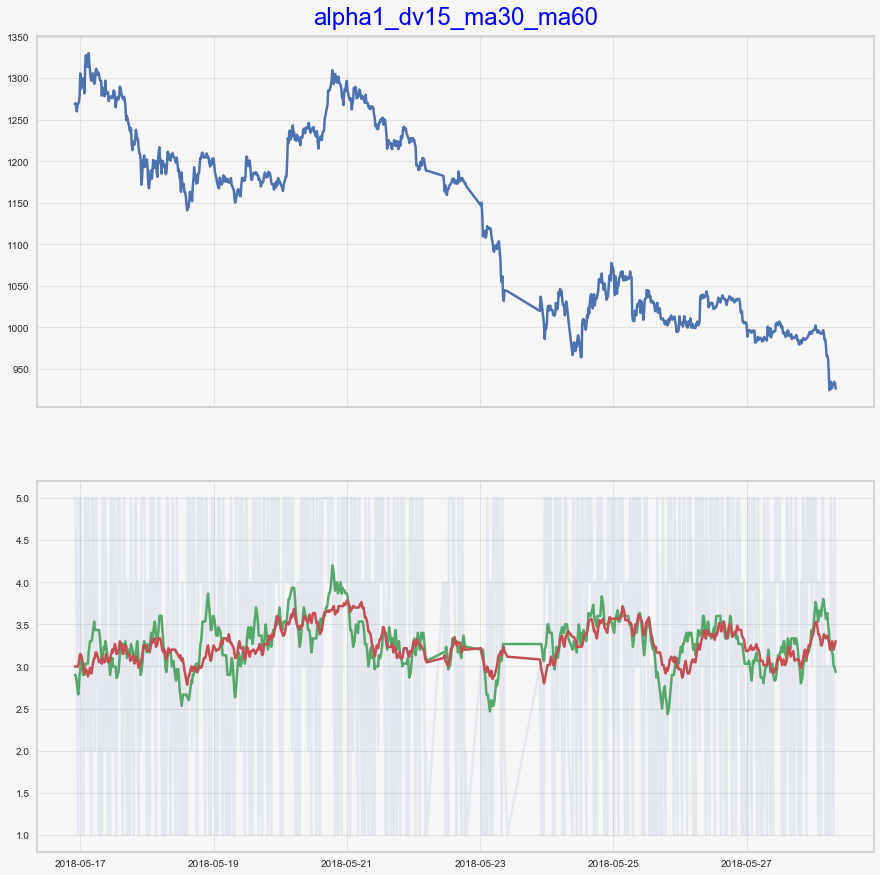

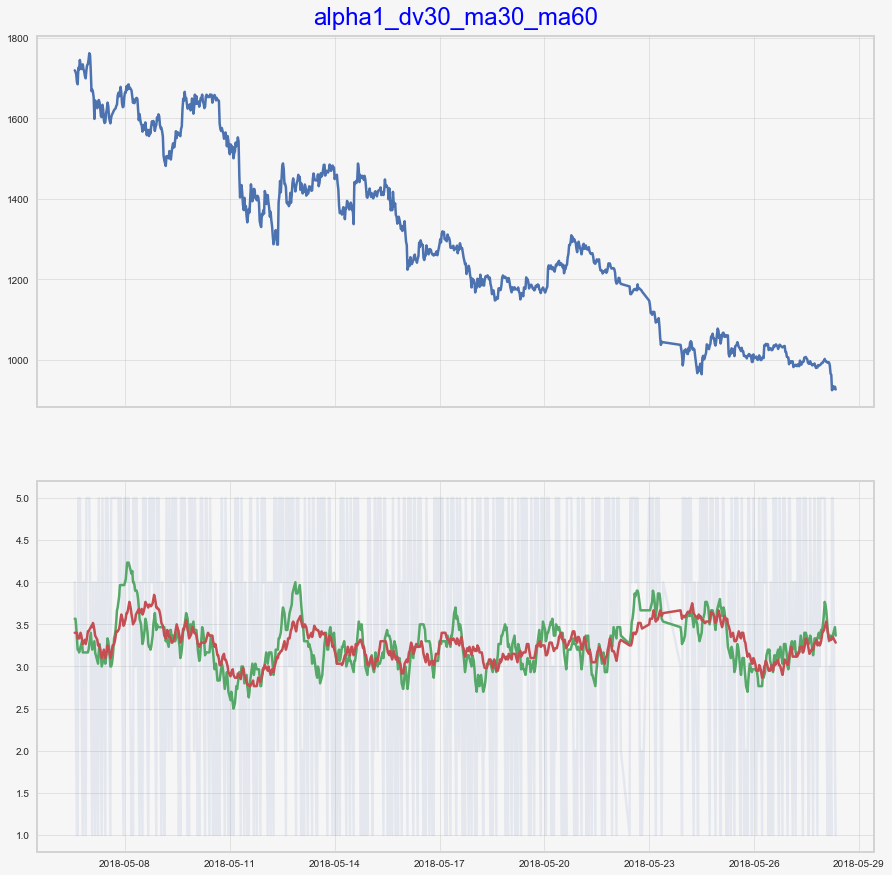

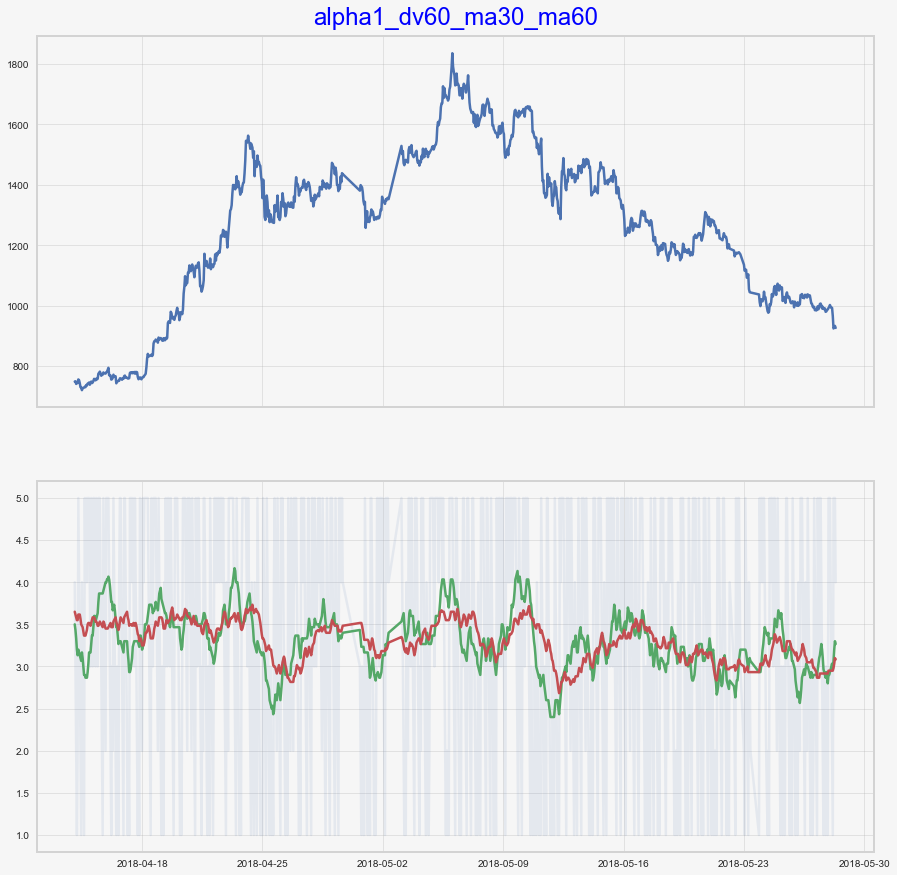

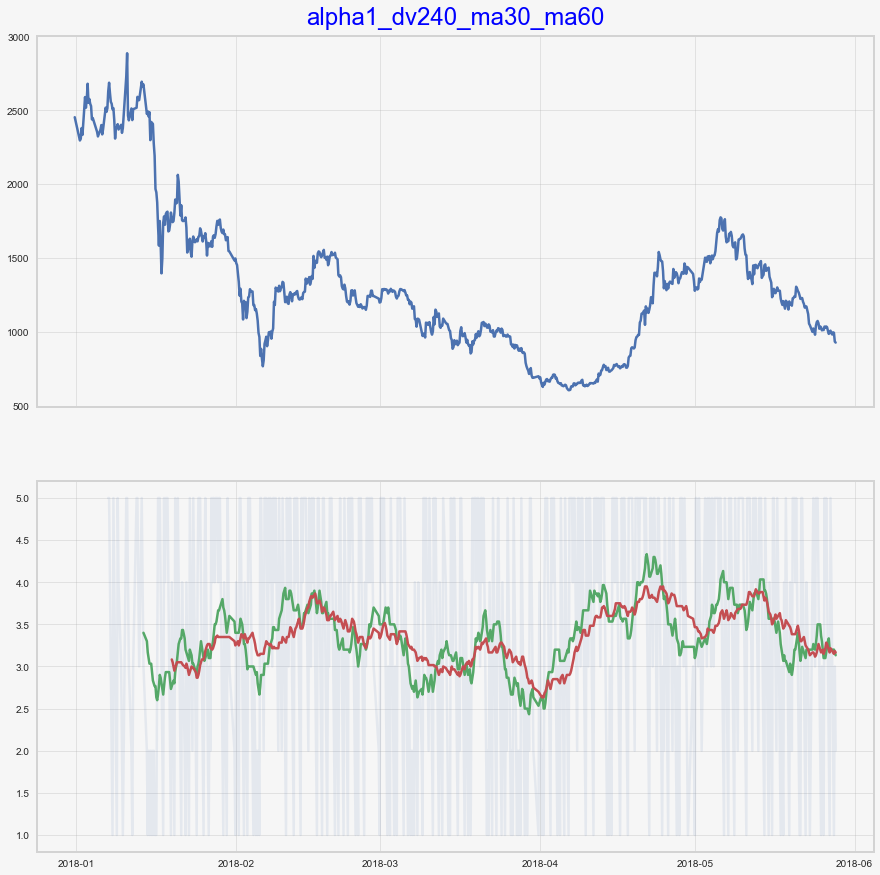

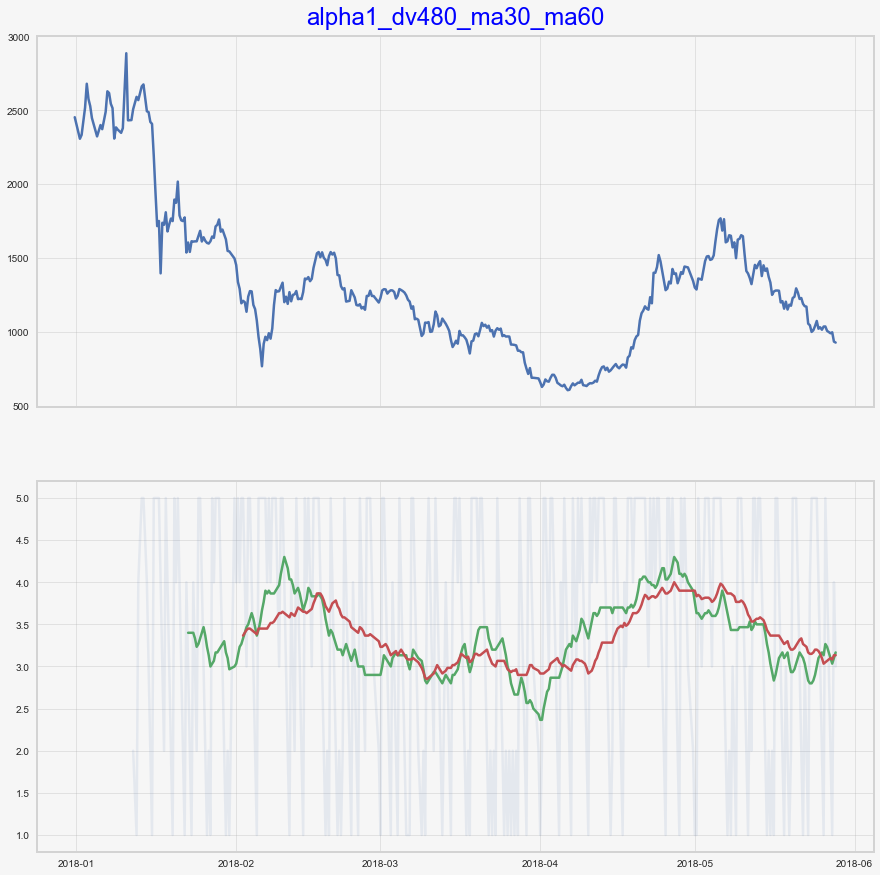

In [43]:
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha, chart_name=name+'_ma30_ma60',ShortPeriod=30, LongPeriod=60, n=-1000)

## 假设 Alpha1在8H下的MA20与MA60金叉死叉收益为0

In [47]:
# 进场信号
long = dv480.add_formula("long","If((Ts_Mean(alpha1_C,30)>Ts_Mean(alpha1_C,60)) && (Delay(Ts_Mean(alpha1_C,30),1)<=Delay(Ts_Mean(alpha1_C,60),1)),2,0)", add_data=True)
short = dv480.add_formula("short","If((Ts_Mean(alpha1_C,30)<Ts_Mean(alpha1_C,60)) && (Delay(Ts_Mean(alpha1_C,30),1)>=Delay(Ts_Mean(alpha1_C,60),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv480.add_formula("close_long","If(short==-2,1,0)", add_data=True)
close_short = dv480.add_formula("close_short","If(long==2,-1,0)", add_data=True)

# 汇总
enter = dv480.add_formula("enter","long+short", add_data=True)
exit = dv480.add_formula("exit","close_long+close_short", add_data=True) 

Field [long] is overwritten.
Field [short] is overwritten.
Field [close_long] is overwritten.
Field [close_short] is overwritten.
Field [enter] is overwritten.
Field [exit] is overwritten.


In [48]:
dv480.get_ts('long').stack()[dv480.get_ts('long').stack()==2]

trade_date      symbol  
20180203000000  btc_usdt    2.0
20180205160000  btc_usdt    2.0
20180306000000  btc_usdt    2.0
20180307080000  btc_usdt    2.0
20180311080000  btc_usdt    2.0
20180316160000  btc_usdt    2.0
20180319080000  btc_usdt    2.0
20180405160000  btc_usdt    2.0
20180525160000  btc_usdt    2.0
20180528080000  btc_usdt    2.0
dtype: float64

In [49]:
from jaqs_fxdayu.research import TimingDigger

# step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称
td1 = TimingDigger(output_folder=".", output_format='pdf')

#多空分别计算一遍 输出汇总结果
td1.process_signal(
    enter_signal=dv480.get_ts("long"),
    exit_signal=dv480.get_ts("close_long"),
    sig_type="long",  # 信号类型 long/short
    price=dv480.get_ts("close"),
    max_holding_period=100,  # 最大持有天数 可为空
#     stoploss=-0.15,  # 止损百分比 负数 可为空
#     stopprofit=0.3,  # 止盈百分比 正数 可为空
)

#多空分别计算一遍 输出汇总结果
td1.process_signal(
    enter_signal=dv480.get_ts("short"),
    exit_signal=dv480.get_ts("close_short"),
    sig_type="short",  # 信号类型 long/short
    price=dv480.get_ts("close"),
    max_holding_period=100,  # 最大持有天数 可为空
#     stoploss=-0.15,  # 止损百分比 负数 可为空
#     stopprofit=0.4,  # 止盈百分比 正数 可为空
)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%


In [50]:
td1.create_event_report(sig_type="long_short",
                       by_symbol=True)

Figure saved: E:\Factor_Scripts\factor-scripts\Alpha101\Alpha_Indicators_Example\long_short_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                       win   loss     all
t-stat               2.959 -3.886   1.752
p-value              0.016  0.005   0.097
mean                 0.350 -0.091   0.141
std                  0.354  0.066   0.341
info_ratio           0.986 -1.374   0.413
skewness             1.363 -0.578   1.776
kurtosis             0.089 -0.671   2.353
pct5                 0.072 -0.197  -0.167
pct25                0.139 -0.127  -0.075
pct50                0.207 -0.078   0.051
pct75                0.293 -0.024   0.207
pct95                1.047 -0.016   1.016
occurance           10.000  9.000  19.000
win_ratio              NaN    NaN   0.526
win_mean/loss_mean     NaN    NaN   3.850


In [51]:
td1.create_event_report(sig_type="long",
                       by_symbol=True)

Figure saved: E:\Factor_Scripts\factor-scripts\Alpha101\Alpha_Indicators_Example\long_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                       win   loss     all
t-stat              30.791 -2.943   1.000
p-value              0.021  0.026   0.347
mean                 1.044 -0.083   0.167
std                  0.034  0.069   0.473
info_ratio          30.791 -1.201   0.353
skewness            -0.000 -0.822   1.278
kurtosis            -2.000 -0.399  -0.256
pct5                 1.013 -0.193  -0.184
pct25                1.027 -0.113  -0.099
pct50                1.044 -0.078  -0.024
pct75                1.060 -0.023  -0.011
pct95                1.074 -0.015   1.050
occurance            2.000  7.000   9.000
win_ratio              NaN    NaN   0.222
win_mean/loss_mean     NaN    NaN  12.521


In [52]:
td1.create_event_report(sig_type="short",
                       by_symbol=True)

Figure saved: E:\Factor_Scripts\factor-scripts\Alpha101\Alpha_Indicators_Example\short_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              5.936 -2.658   2.553
p-value             0.001  0.229   0.031
mean                0.176 -0.117   0.117
std                 0.078  0.044   0.138
info_ratio          2.243 -2.658   0.851
skewness            0.148 -0.000  -0.671
kurtosis           -0.550 -2.000  -0.435
pct5                0.067 -0.156  -0.121
pct25               0.115 -0.139   0.063
pct50               0.200 -0.117   0.158
pct75               0.208 -0.095   0.207
pct95               0.282 -0.077   0.271
occurance           8.000  2.000  10.000
win_ratio             NaN    NaN   0.800
win_mean/loss_mean    NaN    NaN   1.506
